In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import torch
import json
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup


In [2]:
cache_dir='shared_models'
num_labels = 9  
tokenizer = AutoTokenizer.from_pretrained("TurkuNLP/bert-base-finnish-cased-v1", cache_dir=cache_dir)
model = AutoModelForTokenClassification.from_pretrained("TurkuNLP/bert-base-finnish-cased-v1", cache_dir=cache_dir, num_labels=num_labels)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Define the label mapping
label_map = {'o': 0, 'B-P-ORG': 1, 'I-P-ORG': 2, 'B-P-HOB': 3, 'I-P-HOB': 4, 'B-S-ORG': 5, 'I-S-ORG': 6, 'B-S-HOB': 7, 'I-S-HOB': 8}

# Load your data
data = load_data('nerTaggerTrainData123.json')

# Extract all labels from the dataset
all_labels = []
for item in data:
    all_labels.extend(item['labels'])

# Get unique labels and their counts
unique_labels, counts = np.unique(all_labels, return_counts=True)

# Calculate the total number of labels
total_labels = sum(counts)
print("Total",len(data))
# Print the count and percentage of each unique label
print("Label Distribution:")
for label, count in zip(unique_labels, counts):
    percentage = (count / total_labels) * 100
    print(f"Label {label}: Count = {count}, Percentage = {percentage:.2f}%")





In [ ]:
from datasets import load_dataset
import numpy as np


# Load the Conll2003 dataset
conll2003 = load_dataset("conll2003")

# Get label names
label_names = conll2003['train'].features['ner_tags'].feature.names

# Initialize a dictionary to count label occurrences
label_counts = {label: 0 for label in label_names}

# Count occurrences of each label in the training set
for example in conll2003['train']:
    labels = example['ner_tags']
    for label_id in labels:
        label_counts[label_names[label_id]] += 1

# Calculate total number of labels
total_labels = sum(label_counts.values())
print("Total", len(conll2003['train']) + len(conll2003['validation']) +len(conll2003['test']))

# Print label distribution with percentages
print("Label Distribution in Conll2003 Training Set:")
for label, count in label_counts.items():
    percentage = (count / total_labels) * 100
    print(f"{label}: Count = {count}, Percentage = {percentage:.2f}%")


In [3]:
import datasets
import transformers
import evaluate

from pprint import pprint

In [4]:
#add_numeric_ner_tags
import json

# Define the label mapping
label_map = {0: 'o', 1: 'B-P-ORG', 2: 'I-P-ORG', 3: 'B-P-HOB', 4: 'I-P-HOB', 5: 'B-S-ORG', 6: 'I-S-ORG', 7: 'B-S-HOB', 8: 'I-S-HOB'}

# Reverse the label map for easy lookup
reverse_label_map = {v: k for k, v in label_map.items()}

# Load your JSON data
def load_data(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# Save modified data back to JSON
def save_data(data, json_file_path):
    with open(json_file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, indent=4, ensure_ascii=False)

# Add numeric NER tags to your dataset
def add_numeric_ner_tags(data):
    for item in data:
        item['ner_tags'] = [reverse_label_map.get(label, -1) for label in item['labels']]
    return data

# Define your JSON file path
json_file_path = 'nerTaggerTrainData10000withNamesProcessed.json'

# Load, modify, and save your data
data = load_data(json_file_path)
modified_data = add_numeric_ner_tags(data)
save_data(modified_data, json_file_path)

In [5]:
from transformers import AutoTokenizer
import json

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def save_data(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

def process_stories(data, tokenizer, max_samples):
    processed_data = []
    count = 0  # Counter for processed samples
    for entry in data:
        # Stop processing if the maximum number of samples is reached
        if count >= max_samples:
            break

        # Extract the full text, labels, and tags
        full_text = entry['tokenized_text']
        full_ner_tags = entry['ner_tags']
        full_labels = entry['labels']

        # Tokenize the full text and convert to model IDs
        token_ids = tokenizer.convert_tokens_to_ids(full_text)

        # Check if the tokenized text is within the token limit
        if len(token_ids) <= 512:
            processed_data.append({
                'input_ids': token_ids,
                'labels': full_labels,
                'ner_tags': full_ner_tags
            })
            count += 1  # Increment counter
        else:
            print(f"Discarded a story with {len(token_ids)} tokens")

    return processed_data

# Define your original and new JSON file paths
original_json_file_path = 'nerTaggerTrainData10000withNamesProcessed.json'
new_json_file_path = 'nerTagData_processed.json'

# Load the tokenizer
MODEL = "TurkuNLP/bert-base-finnish-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load, process, and save your data
data = load_data(original_json_file_path)
max_samples = 10000  # Set the number of samples to process
processed_data = process_stories(data, tokenizer, max_samples)
save_data(processed_data, new_json_file_path)
print(processed_data[0])


Discarded a story with 526 tokens
Discarded a story with 548 tokens
Discarded a story with 691 tokens
Discarded a story with 523 tokens
Discarded a story with 532 tokens
Discarded a story with 571 tokens
Discarded a story with 599 tokens
Discarded a story with 546 tokens
Discarded a story with 614 tokens
Discarded a story with 537 tokens
Discarded a story with 2649 tokens
Discarded a story with 2802 tokens
{'input_ids': [8571, 9144, 505, 119, 35760, 119, 42926, 111, 4155, 111, 1645, 111, 166, 8022, 3218, 1389, 9060, 111, 2766, 111, 28136, 313, 7633, 114, 111, 115, 111, 4631, 50019, 844, 50075, 119, 23856, 119, 42926, 111, 1490, 111, 788, 111, 166, 750, 3218, 1389, 9060, 111, 23022, 120, 111, 166, 8113, 111, 9048, 236, 15917, 2383, 50013, 166, 8829, 5273, 12849, 111, 36041, 50022, 111, 15722, 236, 3218, 1389, 255, 119, 24969, 2436, 166, 2502, 119, 8381, 1520, 8113, 111, 2666, 6459, 50022, 111, 236, 23071, 109, 50013, 2502, 1520, 8381, 119, 5273, 12849, 8113, 1520, 9239, 119, 25682, 4157

In [9]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import json
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import datasets
import transformers
import evaluate

from pprint import pprint

def process_stories(trimmed_data, tokenizer):
    processed_stories = []

    for story in trimmed_data:
        model_inputs = tokenizer.prepare_for_model(story['input_ids'], 
                                                   truncation=True, 
                                                   padding='max_length', 
                                                   max_length=512)

        processed_story = {
            'input_ids': model_inputs['input_ids'],
            'token_type_ids': model_inputs['token_type_ids'],
            'attention_mask': model_inputs['attention_mask'],
            'labels': story['labels'],
            'ner_tags': story['ner_tags']
        }
        processed_stories.append(processed_story)

    return processed_stories


# Load your trimmed data
trimmed_data_file_path = 'nerTagData_processed.json'
with open(trimmed_data_file_path, 'r', encoding='utf-8') as file:
    trimmed_data = json.load(file)

# Process the data
processed_stories = process_stories(trimmed_data, tokenizer)

# Split the data into train, validation, and test sets
train_data, val_data = train_test_split(processed_stories, test_size=0.1)
#val_data, test_data = train_test_split(temp_data, test_size=(5/15))

# Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))
#test_dataset = Dataset.from_pandas(pd.DataFrame(test_data))

# Combine into a single DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
#    'test': test_dataset
})


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
print(dataset)

In [7]:
id2label  = {0: 'o', 1: 'B-P-ORG', 2: 'I-P-ORG', 3: 'B-P-HOB', 4: 'I-P-HOB', 5: 'B-S-ORG', 6: 'I-S-ORG', 7: 'B-S-HOB', 8: 'I-S-HOB'}
label2id ={'o': 0, 'B-P-ORG': 1, 'I-P-ORG': 2, 'B-P-HOB': 3, 'I-P-HOB': 4, 'B-S-ORG': 5, 'I-S-ORG': 6, 'B-S-HOB': 7, 'I-S-HOB': 8} 
label_names = ['o','B-P-ORG', 'I-P-ORG', 'B-P-HOB', 'I-P-HOB', 'B-S-ORG', 'I-S-ORG', 'B-S-HOB', 'I-S-HOB']


In [ ]:
# Display the first element in data and how tokens and ner tags correlate
first_story = trimmed_data[0]

# Convert token IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(first_story['input_ids'])

# Align tokens with NER tags
line1 = ""
line2 = ""
for token, label in zip(tokens, first_story['ner_tags']):
    # Assuming id2label maps label IDs to label names
    label_name = id2label[label]
    
    # Calculate max length for formatting
    max_length = max(len(token), len(label_name))
    
    line1 += token + " " * (max_length - len(token) + 1)
    line2 += label_name + " " * (max_length - len(label_name) + 1)

# Print the formatted lines
print(line1)
print(line2)

In [ ]:
from itertools import zip_longest
# Process the first entry in the training set
first_entry = dataset['train'][0]

# Convert token IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(first_entry['input_ids'])

# Align tokens with NER tags
for token, tag_id in zip_longest(tokens, first_entry['ner_tags']):
    # Check if tag_id is not None and is in id2label
    tag = id2label[tag_id] if tag_id is not None and tag_id in id2label else "None"
    print(f'{token}\t{tag}')

In [ ]:
# Process the first entry in the training set
first_entry = dataset['train'][0]

# Get the token IDs and the corresponding NER tags
input_ids = first_entry['input_ids']
ner_tags = first_entry['labels']

# Initialize the list for the aligned NER tags
aligned_ner_tags = []
i = 0  # Index for the original ner_tags

# Align the NER tags with the tokenized input
for token_id in input_ids:
    token = tokenizer.convert_ids_to_tokens(token_id)
    if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        aligned_ner_tags.append(-100)  # Special tokens get -100
    else:
        aligned_ner_tags.append(ner_tags[i])
        i += 1  # Move to the next original NER tag

# Print the results
for token_id, ner_tag in zip(input_ids, aligned_ner_tags):
    token = tokenizer.convert_ids_to_tokens(token_id)
    print(f'{token}\t{ner_tag}')

In [10]:
# Define a function to align NER tags with tokenized input
def align_ner_tags(example):
    input_ids = example['input_ids']
    ner_tags = example['ner_tags']
    
    # Initialize the list for the aligned NER tags
    aligned_ner_tags = []
    i = 0  # Index for the original ner_tags

    # Align the NER tags with the tokenized input
    for token_id in input_ids:
        token = tokenizer.convert_ids_to_tokens(token_id)
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            aligned_ner_tags.append(-100)  # Special tokens get -100
        else:
            aligned_ner_tags.append(ner_tags[i])
            i += 1  # Move to the next original NER tag

    return {'input_ids': input_ids, 'labels': aligned_ner_tags}

# Apply the function to the entire dataset
processed_dataset = dataset.map(align_ner_tags)



Map:   0%|          | 0/8990 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
# Optionally, print the first few aligned entries to verify
for split in processed_dataset.keys():
    print(f"Split: {split}")
    for i in range(3):
        print(f"Example {i+1} in {split} split:")
        example = processed_dataset[split][i]  # Access the example in the specific split
        for token_id, ner_tag in zip(example['input_ids'], example['labels']):
            token = tokenizer.convert_ids_to_tokens(token_id)
            print(f'{token}\t{ner_tag}')
        print("\n")


In [ ]:
#see if aligned

token_ids = processed_dataset['train'][1]['input_ids']
tag_ids = processed_dataset['train'][1]['labels']
print(token_ids)
print(tag_ids)

for token_id, tag_id in zip_longest(token_ids, tag_ids):
    token = tokenizer.convert_ids_to_tokens(token_id)
    tag = id2label[tag_id] if tag_id != -100 else None
    print(f'{token}\t{tag}')
     


In [11]:
import transformers
MODEL ="TurkuNLP/bert-base-finnish-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
num_labels = 9  
model = transformers.AutoModelForTokenClassification.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import seqeval

metrics = evaluate.load('seqeval')

def compute_metrics(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[i] for i in label if i != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metrics.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': all_metrics['overall_precision'],
        'recall': all_metrics['overall_recall'],
        'f1': all_metrics['overall_f1'],
        'accuracy': all_metrics['overall_accuracy'],
    }

In [13]:
def remove_unused_columns(example):
    # Define the keys you want to keep
    keys_to_keep = ['input_ids', 'attention_mask', 'labels']

    
    return {key: example[key] for key in keys_to_keep}

for split in dataset.keys():
    processed_dataset[split] = processed_dataset[split].map(remove_unused_columns, 
                                                  remove_columns=dataset[split].column_names)


Map:   0%|          | 0/8990 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [14]:


from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)




In [ ]:
print(processed_dataset)

In [30]:


trainer_args = transformers.TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='steps',
    logging_strategy='steps',
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    save_steps=100,
    #metric_for_best_model='f1'
    save_total_limit=5,
    learning_rate=0.00002,
    per_device_train_batch_size=16, #optional higher 
    per_device_eval_batch_size=32, 
    max_steps=1500, #optional higher number
)

     

In [31]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()
     


In [32]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[training_logs], 
)

In [33]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,0.020000,0.036348,0.747088,0.782688,0.764474,0.989577
200,0.020200,0.036568,0.737812,0.778566,0.757641,0.989282
300,0.017500,0.036991,0.742902,0.785161,0.763447,0.989540
400,0.018200,0.036189,0.753273,0.787304,0.769913,0.989958
500,0.018200,0.038341,0.748483,0.793405,0.770290,0.989813
600,0.016600,0.038002,0.757911,0.789777,0.773516,0.989947
700,0.013100,0.038129,0.759660,0.781204,0.770281,0.989958
800,0.012400,0.038810,0.749726,0.788293,0.768526,0.989759
900,0.013300,0.040115,0.754569,0.776092,0.765179,0.989658
1000,0.012500,0.040225,0.759968,0.795054,0.777115,0.990038


/users/laatojoo/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/users/laatojoo/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/users/laatojoo/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/users/laatojoo/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/users/laatojoo/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/users/laatojoo/.local/lib/python3.

TrainOutput(global_step=1500, training_loss=0.014681499083836874, metrics={'train_runtime': 607.1099, 'train_samples_per_second': 39.532, 'train_steps_per_second': 2.471, 'total_flos': 6270473786314752.0, 'train_loss': 0.014681499083836874, 'epoch': 2.67})

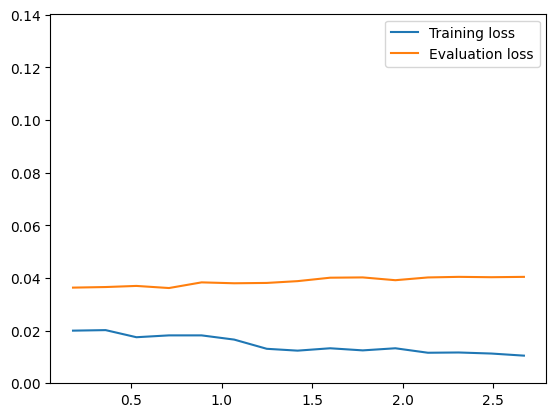

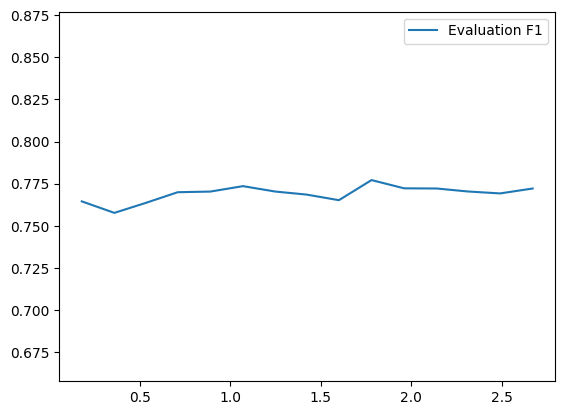

In [34]:
import os
import matplotlib.pyplot as plt

def save_f1_scores_to_file(logs, filename, folder="model_results"):
    # Ensure the folder exists
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename + "_f1_scores.txt")

    with open(filepath, "w") as file:
        for epoch, f1_score in zip(logs['epoch'], logs['eval_f1']):
            file.write(f"Epoch {epoch}: F1 Score = {f1_score}\n")

def plot_and_save(logs, keys, labels, filename, folder="model_results"):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs['epoch'], logs[key], label=label)
    plt.legend()

    # Ensure the folder exists
    os.makedirs(folder, exist_ok=True)
    plt.savefig(os.path.join(folder, filename + ".png"))
    plt.show()

# Example usage
identifier = "dataset_size_10000withNames"  # Replace X with actual size or identifier

# Save F1 scores to a file
save_f1_scores_to_file(training_logs.logs, identifier)

# Save plot to an image file
plot_and_save(training_logs.logs, ['loss', 'eval_loss'], ['Training loss', 'Evaluation loss'], identifier)
plot_and_save(training_logs.logs, ['eval_f1'], ['Evaluation F1'], identifier)


In [6]:
pipe = transformers.pipeline(
    'token-classification',
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy='simple',
    device=0
)

In [26]:
pipe("""

rouva, synt. 31. 10. -16 Kirvussa. Puol. Sakari Paavo, dipl.kauppias, synt. 2. 12. 18 Akaalla.Avioit. -45. Lapset: Pirkko Helena -46, Pertti Sakari -50, Riitta Maria -56, Liisa Marjatta -59. Syntyneet Joutsenossa. Asuinp. Karjalassa: Kirvu, Räty. Muut asuinp.: Joutseno, Honkalahti. Simolat asuvat omakotitalossaan. Sakari Simola ön sotilasarvoltaan kersantti. Hän on ollut Joutsenon kunnanhallituksen. Osuuskassan hallituk-son. asutuslautakunnan, kansalaiskoulun johtokunnan, urheilulautakunnan ja liikennelautakun-nan jäsen. Joutsenon metsästysseuran puheen johtaja. Joutsenon Kullervon Tuki ry;n puh.joht ja Vähiltäiskauppiasliiton Lappeenrannan piirin johtokunnan jäsen. Hän on innokas metsämies ja kalastaja Rouva Simola on osallistunut sodan aikana lottatoimintaan. Hän on Kauppiaitten naiset ry:n jäsen. Harrastuksena on kirjallisuus.
""")



[{'entity_group': 'o',
  'score': 0.99910086,
  'word': 'rouva, synt. 31. 10. - 16 Kirvussa. Puol. Sakari Paavo, dipl. kauppias, synt. 2. 12. 18 Akaalla. Avioit. - 45. Lapset : Pirkko Helena - 46, Pertti Sakari - 50, Riitta Maria - 56, Liisa Marjatta - 59. Syntyneet Joutsenossa. Asuinp. Karjalassa : Kirvu, Räty. Muut asuinp. : Joutseno, Honkalahti. Simolat asuvat omakotitalossaan. Sakari Simola ön sotilasarvoltaan kersantti. Hän on ollut',
  'start': 2,
  'end': 375},
 {'entity_group': 'S-ORG',
  'score': 0.7572661,
  'word': 'Joutsenon kunnanhallituksen',
  'start': 376,
  'end': 403},
 {'entity_group': 'o',
  'score': 0.9790084,
  'word': '.',
  'start': 403,
  'end': 404},
 {'entity_group': 'S-ORG',
  'score': 0.9100711,
  'word': 'Osuuskassan hallituk - son. asutuslautakunnan',
  'start': 405,
  'end': 448},
 {'entity_group': 'o',
  'score': 0.95478857,
  'word': ',',
  'start': 448,
  'end': 449},
 {'entity_group': 'S-ORG',
  'score': 0.96823555,
  'word': 'kansalaiskoulun johtoku

In [36]:
cache_dir = 'shared_models'
model_save_path = cache_dir + '/ner-finnish-model-size10000'
model.save_pretrained(model_save_path)

In [7]:
def load_model(model_dir, pretrained_model_name):
    # Load tokenizer from the original pre-trained model
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

    # Load your fine-tuned model from the specified directory
    model = AutoModelForTokenClassification.from_pretrained(model_dir, local_files_only=True)

    return model, tokenizer

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def format_ner_results(ner_results, threshold=0.0):  # set a default threshold value
    # Function to format the NER results, filtering out low-scoring entities
    formatted_results = []
    for result in ner_results:
        # Check if the score is below the threshold
        if result['score'] < threshold:
            result['entity_group'] = 'o'  # label it as 'o'
        # Append the result regardless of the score
        formatted_results.append({'token': result['word'], 'tag': result['entity_group'], 'score': result['score']})
    return formatted_results

def process_stories(json_file_path, model, tokenizer, threshold):
    # Load the stories
    stories = load_data(json_file_path)
    results = []

    # Initialize the pipeline
    pipe = transformers.pipeline(
        'token-classification',
        model=model,
        tokenizer=tokenizer,
        aggregation_strategy='simple',
        device=0
    )

# Process each story
    for story in stories:
        # Format the primary person's name to be natural
        primary_person_name = " ".join(word.capitalize() for word in story["primary_person_name"].split())
        
        # Add the formatted primary person's name to the beginning of the source text
        source_text = primary_person_name + ", " + story.get('source_text', '')
        
        ner_predictions = pipe(source_text)
        # Pass the threshold to the format_ner_results function
        story_results = format_ner_results(ner_predictions, threshold)
        
        # Append the story with the formatted name and the entities found
        results.append({'story': source_text, 'entities': story_results})

    return results



model_dir = 'shared_models/ner-finnish-model-lr-0.0001-bs-16-ms-2500'


# Specify the name of the original pre-trained model
pretrained_model_name = "TurkuNLP/bert-base-finnish-cased-v1"

# Specify the file path for the test data
json_file_path = 'Samples/sample_siirtokarjalaiset_NOT_annotated.json'
score_threshold = 0.0  # Set the desired score threshold




model, tokenizer = load_model(model_dir, pretrained_model_name)
processed_stories = process_stories(json_file_path, model, tokenizer, score_threshold)


/users/laatojoo/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
def print_formatted_results(results):
    for index, result in enumerate(results, start=1):  # start=1 begins counting from 1
        print(f"\nStory {index}:", result['story'])
        print("Entities and confidence scores found:")
        for entity in result['entities']:
            # Print each entity with its tag and confidence score
            print(f"  - {entity['token']} ({entity['tag']}, Score: {entity['score']:.2f})")  # Formats score to two decimal places

# Call this function with the processed stories
print_formatted_results(processed_stories)



In [ ]:
def print_unique_or_low_confidence_results(results1, results2, threshold=0.70):
    for index, (result1, result2) in enumerate(zip(results1, results2), start=1):
        set1 = {entity['token'] for entity in result1['entities'] if entity['tag'] != 'o' and entity['score'] >= threshold}
        set2 = {entity['token'] for entity in result2['entities'] if entity['tag'] != 'o' and entity['score'] >= threshold}

        entities_of_interest_model1 = [
            entity for entity in result1['entities'] 
            if entity['tag'] != 'o' and (entity['token'] not in set2 or entity['score'] < threshold)
        ]

        entities_of_interest_model2 = [
            entity for entity in result2['entities'] 
            if entity['tag'] != 'o' and (entity['token'] not in set1 or entity['score'] < threshold)
        ]

        if entities_of_interest_model1 or entities_of_interest_model2:
            print(f"\nStory {index} Summary:")

            if entities_of_interest_model1:
                print("\nfound only in Model 1")
                for entity in entities_of_interest_model1:
                    print(f"  - {entity['token']} ({entity['tag']}, Score: {entity['score']:.2f})")

            if entities_of_interest_model2:
                print("\nEntities found only in Model 2 without Names")
                for entity in entities_of_interest_model2:
                    print(f"  - {entity['token']} ({entity['tag']}, Score: {entity['score']:.2f})")

# Call this function with the processed stories from both
# Call this function with the processed stories from both models
print_unique_or_low_confidence_results(processed_stories, processed_stories1)




In [ ]:
def print_formatted_results(results):
    for index, result in enumerate(results, start=1):  # start=1 begins counting from 1
        print(f"\nStory {index} Summary:")

        # Filter out entities with label 'O' and sort the remaining entities by their confidence scores
        filtered_sorted_entities = sorted(
            [entity for entity in result['entities'] if entity['tag'] != 'o'],
            key=lambda e: e['score']
        )

        if not filtered_sorted_entities:
            print("No relevant entities found.")
        else:
            print("Entities and confidence scores found:")
            for entity in filtered_sorted_entities:
                # Print each entity with its tag and confidence score
                print(f"  - {entity['token']} ({entity['tag']}, Score: {entity['score']:.2f})")  # Formats score to two decimal places

# Call this function with the processed stories
print_formatted_results(processed_stories)



In [8]:
# Modified script to save the formatted results into a JSON file

def post_process_stories(original_stories, processed_stories):
    formatted_responses = []

    for index, (original_story, processed_story) in enumerate(zip(original_stories, processed_stories), start=1):
        person_hobbies = []
        person_social_orgs = []
        spouse_hobbies = []
        spouse_social_orgs = []

        # Extract hobbies and social organizations from processed_story
        for entity in processed_story['entities']:
            if entity['tag'] == 'P-HOB':
                person_hobbies.append(entity['token'])
            elif entity['tag'] == 'P-ORG':
                person_social_orgs.append(entity['token'])
            elif entity['tag'] == 'S-HOB':
                spouse_hobbies.append(entity['token'])
            elif entity['tag'] == 'S-ORG':
                spouse_social_orgs.append(entity['token'])

        # Build the formatted response
        formatted_response = {
            'batch_number': index,
            'person_index': index,
            'api_response': f"PersonID: {original_story['primary_person_id']}\n"
                            f"PersonName: {original_story['primary_person_name']}\n"
                            f"PersonHobbies: {', '.join(person_hobbies)}\n"
                            f"PersonSocialOrgs: {', '.join(person_social_orgs)}\n"
                            f"SpouseID: {original_story['spouse_id']}\n"
                            f"SpouseName: {original_story['spouse_name']}\n"
                            f"SpouseHobbies: {', '.join(spouse_hobbies)}\n"
                            f"SpouseSocialOrgs: {', '.join(spouse_social_orgs)}"
        }
        formatted_responses.append(formatted_response)

    return formatted_responses

def save_to_json(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

        
# Load original stories data
original_stories = load_data('Samples/sample_siirtokarjalaiset_NOT_annotated.json')
        
# Assuming 'original_stories' and 'processed_stories' are already loaded
# Post process to get the formatted results
formatted_results = post_process_stories(original_stories, processed_stories)

# Save the formatted results to a JSON file
output_file_path = 'processed_stories_results.json'
save_to_json(formatted_results, output_file_path)


# Print the formatted results
for result in formatted_results:
    print(result['api_response'])


PersonID: siirtokarjalaiset_2_15772P
PersonName: TOIVO JOHANNES JANATUINEN
PersonHobbies: hiihtoa, nyrkkeilyä
PersonSocialOrgs: SKP, Eläkeläisten kerho
SpouseID: siirtokarjalaiset_2_15772S_1
SpouseName: Hanna Pukarinen
SpouseHobbies: 
SpouseSocialOrgs: 
PersonID: siirtokarjalaiset_2_17390P
PersonName: TOIVO RAVANTTI
PersonHobbies: metsästys, kalastus
PersonSocialOrgs: Lopen Karjalaiset ry, verolautakunnassa, Sajaniemen Hirviveikot ry
SpouseID: siirtokarjalaiset_2_17390S_1
SpouseName: Aino Inkeri Luukka
SpouseHobbies: käsityöt, puutarhanhoito
SpouseSocialOrgs: Lopen Karjalaiset ry, Lopen Kuparsaaren Marttojen
PersonID: siirtokarjalaiset_2_16619P
PersonName: MAUNO TAPANI KALMI
PersonHobbies: kirjallisuutta
PersonSocialOrgs: Reservialiupseerien Kärkölän osaston, Kärkölän Sotaveteraanien jäsen, maatalousalan eri järjestöjen
SpouseID: siirtokarjalaiset_2_16619S_1
SpouseName: Elsa Kaarina Ahonen
SpouseHobbies: kirjallisuutta, maalausta
SpouseSocialOrgs: maatalous - ja kotitalousalan naisjärj